## Create the dataset

In [1]:
import os
import shutil
import random

In [2]:
def split_dataset(dataset_path, train_ratio=0.7, val_ratio=0.3):
    """
    Splits the dataset into train and validation sets.

    Args:
        dataset_path: The path to the dataset directory.
        train_ratio: The ratio of images to be used for training.
        val_ratio: The ratio of images to be used for validation.
    """

    # Create train and validation directories
    train_dir = os.path.join(dataset_path, 'train_70')
    val_dir = os.path.join(dataset_path, 'val_30')
    dataset_path = os.path.join(dataset_path, 'Segmented Medicinal Leaf Images')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    total_images = 0

    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            total_images += len(images)

            random.shuffle(images)
            train_split = int(len(images) * train_ratio)
            val_split = int(len(images) * (train_ratio + val_ratio))

            # Copy images to train directory
            for image in images[:train_split]:
                src = os.path.join(class_path, image)
                dst = os.path.join(train_dir, class_name, image)
                os.makedirs(os.path.dirname(dst), exist_ok=True)
                shutil.copyfile(src, dst)
            
            # Copy images to validation directory
            for image in images[train_split:val_split]:
                src = os.path.join(class_path, image)
                dst = os.path.join(val_dir, class_name, image)
                os.makedirs(os.path.dirname(dst), exist_ok=True)
                shutil.copyfile(src, dst)
    
    print(total_images)

dataset_path = r"C:\Users\CoolA\Code\Medicinal Leaves\Dataset 1"
split_dataset(dataset_path)

1835


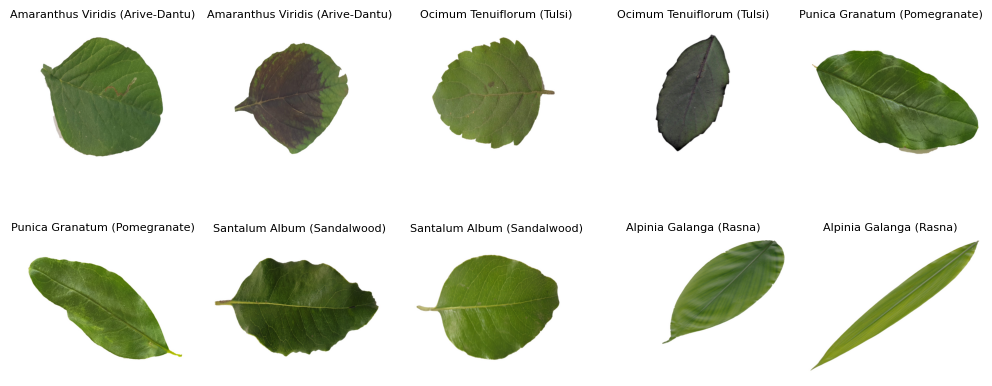

In [1]:
import os
import random
import matplotlib.pyplot as plt

def get_random_images(train_folder, num_images_per_species=2, max_species=5):
  """
  Selects random images from multiple subfolders within a train folder.

  Args:
    train_folder: Path to the main train folder.
    num_images_per_species: Number of random images to select per species.
    max_species: Maximum number of species to sample from.

  Returns:
    A list of image paths and a list of corresponding species labels.
  """

  image_paths = []
  species_labels = []
  selected_species = random.sample(os.listdir(train_folder), max_species)
  for species_folder in selected_species:
    species_path = os.path.join(train_folder, species_folder)
    if os.path.isdir(species_path):
      images = [os.path.join(species_path, img) for img in os.listdir(species_path)]
      selected_images = random.sample(images, min(num_images_per_species, len(images)))
      image_paths.extend(selected_images)
      species_labels.extend([species_folder] * len(selected_images))
  return image_paths, species_labels

# Example usage
train_folder = r"C:\Users\CoolA\Code\Medicinal Leaves\Dataset 1\train_70"  # Replace with the actual path
image_paths, species_labels = get_random_images(train_folder)

# Display the images with annotations
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
  img = plt.imread(image_paths[i])
  ax.imshow(img)
  ax.set_title(species_labels[i], fontsize=8)  # Set species as title
  ax.axis('off')
plt.tight_layout()
plt.show()

In [3]:
def count_images(folder_path):
    """
    Counts the number of images in a folder recursively.

    Args:
        folder_path: The path to the folder.

    Returns:
        The total number of images in the folder.
    """
    total_images = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                total_images += 1
    return total_images

dataset_dir = r"C:\Users\CoolA\Code\Medicinal Leaves\Dataset 1\Segmented Medicinal Leaf Images"
train_dir = r"C:\Users\CoolA\Code\Medicinal Leaves\Dataset 1\train_70"
val_dir = r"C:\Users\CoolA\Code\Medicinal Leaves\Dataset 1\val_30"

train_count = count_images(train_dir)
val_count = count_images(val_dir)
dataset_count = count_images(dataset_dir)

print("Number of images in the dataset:", dataset_count)
print("Number of images in train folder:", train_count)
print("Number of images in validation folder:", val_count)

Number of images in the dataset: 1835
Number of images in train folder: 1273
Number of images in validation folder: 562


## Dataset preparation

In [5]:
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset

In [6]:
def create_datasets_and_loaders():
    # Base transform
    base_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Augmentations
    augmentations = transforms.Compose([
        transforms.RandomResizedCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.2)
    ])

    # Load the original dataset
    original_dataset = torchvision.datasets.ImageFolder(root=r'C:\Users\CoolA\Code\Medicinal Leaves\Dataset 1\train', transform=base_transform)

    # Create an augmented dataset
    augmented_dataset = torchvision.datasets.ImageFolder(root=r'C:\Users\CoolA\Code\Medicinal Leaves\Dataset 1\train', transform=augmentations)

    # Combine the original and augmented datasets
    trainset = ConcatDataset([original_dataset, augmented_dataset])

    # Create data loaders
    trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

    valset = torchvision.datasets.ImageFolder(root=r'C:\Users\CoolA\Code\Medicinal Leaves\Dataset 1\val', transform=base_transform)
    valloader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=2)

    return trainloader, valloader

## Models list

In [7]:
models_list = [
    models.resnet50(pretrained=True),
    models.mobilenet_v2(pretrained=True),
    models.densenet121(pretrained=True),
    models.efficientnet_b0(pretrained=True),
    models.vgg16(pretrained=True),
    models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
]

c:\Users\CoolA\Code\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\CoolA\Code\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\CoolA\Code\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the 

In [8]:
results = []

for model in models_list:
    # Reset datasets and dataloaders
    trainloader, valloader = create_datasets_and_loaders()

    # Setting up the final fully connected layer
    if isinstance(model, models.ResNet):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 30)
    elif isinstance(model, models.MobileNetV2):
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, 30)
    elif isinstance(model, models.DenseNet):
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, 30)
    elif isinstance(model, models.EfficientNet):
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, 30)
    elif isinstance(model, models.VGG):
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, 30)
    elif isinstance(model, models.ConvNeXt):
        num_ftrs = model.classifier[2].in_features
        model.classifier[2] = torch.nn.Linear(num_ftrs, 30)
        
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    # Print the number of parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Parameters of {type(model).__name__}:",total_params)
    
    # Training
    num_epochs = 10
    model_results = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        avg_loss = running_loss / len(trainloader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
        
        # Evaluation on training set
        model.eval()
        correct_train = 0
        total_train = 0
        with torch.no_grad():
            for data in trainloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct_train / total_train
        print(f'Accuracy on training set: {train_accuracy:.2f}%')
        
        # Evaluation on validation set
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_accuracy = 100 * correct_val / total_val
        print(f'Accuracy on validation set: {val_accuracy:.2f}%')
        
        model_results.append({
            'epoch': epoch + 1,
            'loss': avg_loss,
            'train_accuracy': train_accuracy,
            'val_accuracy': val_accuracy
        })
    
    results.append({
        'model': type(model).__name__,
        'epochs': model_results
    })
    
    print(f"Finished training {type(model).__name__}")
    print('-' * 50)

Parameters of ResNet: 23569502
Epoch 1, Loss: 1.4785
Accuracy on training set: 61.86%
Accuracy on validation set: 67.63%
Epoch 2, Loss: 0.8100
Accuracy on training set: 70.48%
Accuracy on validation set: 72.89%
Epoch 3, Loss: 0.5785
Accuracy on training set: 79.14%
Accuracy on validation set: 84.21%
Epoch 4, Loss: 0.5007
Accuracy on training set: 77.49%
Accuracy on validation set: 83.68%
Epoch 5, Loss: 0.4437
Accuracy on training set: 83.09%
Accuracy on validation set: 87.63%
Epoch 6, Loss: 0.3529
Accuracy on training set: 70.79%
Accuracy on validation set: 77.11%
Epoch 7, Loss: 0.3804
Accuracy on training set: 88.90%
Accuracy on validation set: 91.05%
Epoch 8, Loss: 0.3259
Accuracy on training set: 87.59%
Accuracy on validation set: 92.11%
Epoch 9, Loss: 0.3435
Accuracy on training set: 85.09%
Accuracy on validation set: 88.68%
Epoch 10, Loss: 0.3004
Accuracy on training set: 91.48%
Accuracy on validation set: 94.47%
Finished training ResNet
-------------------------------------------

## Printing results

In [9]:
# Print the results
for model_result in results:
    print(f"Results for {model_result['model']}:")
    for epoch_result in model_result['epochs']:
        print(f"Epoch {epoch_result['epoch']}: Loss={epoch_result['loss']:.4f}, "
              f"Train Acc={epoch_result['train_accuracy']:.2f}%, "
              f"Val Acc={epoch_result['val_accuracy']:.2f}%")
    print('-' * 50)

Results for ResNet:
Epoch 1: Loss=1.4785, Train Acc=61.86%, Val Acc=67.63%
Epoch 2: Loss=0.8100, Train Acc=70.48%, Val Acc=72.89%
Epoch 3: Loss=0.5785, Train Acc=79.14%, Val Acc=84.21%
Epoch 4: Loss=0.5007, Train Acc=77.49%, Val Acc=83.68%
Epoch 5: Loss=0.4437, Train Acc=83.09%, Val Acc=87.63%
Epoch 6: Loss=0.3529, Train Acc=70.79%, Val Acc=77.11%
Epoch 7: Loss=0.3804, Train Acc=88.90%, Val Acc=91.05%
Epoch 8: Loss=0.3259, Train Acc=87.59%, Val Acc=92.11%
Epoch 9: Loss=0.3435, Train Acc=85.09%, Val Acc=88.68%
Epoch 10: Loss=0.3004, Train Acc=91.48%, Val Acc=94.47%
--------------------------------------------------
Results for MobileNetV2:
Epoch 1: Loss=0.8022, Train Acc=82.37%, Val Acc=86.32%
Epoch 2: Loss=0.3336, Train Acc=95.95%, Val Acc=98.95%
Epoch 3: Loss=0.3015, Train Acc=93.64%, Val Acc=94.74%
Epoch 4: Loss=0.2231, Train Acc=94.09%, Val Acc=97.11%
Epoch 5: Loss=0.2304, Train Acc=93.57%, Val Acc=97.11%
Epoch 6: Loss=0.1716, Train Acc=96.36%, Val Acc=98.68%
Epoch 7: Loss=0.1403, T